## Sentiment Analysis of Amazon Review Data

In [3]:
import json
import pandas as pd
import re
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2, SelectPercentile, f_classif
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression

In [4]:
with open('config.json') as json_data_file:
    config = json.load(json_data_file)

In [5]:
data = pd.read_csv("./Data_filtered/reviews_Automotive.csv", sep=";")
data.head(5)

,review,rating,product
0,"['needed', 'set', 'jumper', 'cables', 'new', '...",5.0,B00002243X
1,"['long', 'cables', 'work', 'fine', 'truck', 'q...",4.0,B00002243X
2,"['comment', 'much', 'since', 'yet', 'used', 'c...",5.0,B00002243X
3,"['absolutley', 'love', 'amazon', 'price', 'set...",5.0,B00002243X
4,"['purchased', 'twelve', 'feet', 'long', 'cable...",5.0,B00002243X


In [6]:
# 1, 2, 3 = negativ 4, 5 = positiv
data["label"] = pd.cut(data["rating"], bins = config["label_two"]["bins"], labels = config["label_two"]["labels"])
data["label"] = data["label"].astype(str)
data.head(5)

,review,rating,product,label
0,"['needed', 'set', 'jumper', 'cables', 'new', '...",5.0,B00002243X,positiv
1,"['long', 'cables', 'work', 'fine', 'truck', 'q...",4.0,B00002243X,positiv
2,"['comment', 'much', 'since', 'yet', 'used', 'c...",5.0,B00002243X,positiv
3,"['absolutley', 'love', 'amazon', 'price', 'set...",5.0,B00002243X,positiv
4,"['purchased', 'twelve', 'feet', 'long', 'cable...",5.0,B00002243X,positiv


In [7]:
X_train, X_test, y_train, y_test = train_test_split(data['review'], data['label'], test_size=0.2, random_state=42, stratify=data['label'])

#Vectorizer
vect = CountVectorizer()
#vect = TfidfVectorizer()

#feature selection
f_select = SelectKBest(f_classif, k=10000)
f_select = SelectPercentile(f_classif, percentile=20)

from sklearn.ensemble import RandomForestClassifier

#Classifier
clf = MultinomialNB(alpha=1.0, class_prior=None, fit_prior=False)
#clf = LinearSVC(C=1.0, penalty= "l1", max_iter=3000, dual=False)
#clf = RandomForestClassifier(n_estimators=1000, max_depth=2, random_state=42)
#clf = LogisticRegression(random_state=42, class_weight=None, max_iter=3000)



#Building the Pipeline
pipeline = Pipeline([('vect', vect),
                     ('f_select', f_select), 
                     ('clf', clf)])

In [8]:
from sklearn import metrics
model = pipeline.fit(X_train, y_train)

#Results step of Pipeline
vectorizer = model.named_steps['vect']
feature_selection = model.named_steps['f_select']
classifier = model.named_steps['clf']


#Accuracy score of Train Data
print("accuracy score: " + str(model.score(X_train, y_train)))

accuracy score: 0.9322261570399316


In [9]:
from sklearn.metrics import accuracy_score
model = pipeline.fit(X_train, y_train)

#Accuracy Score of Model prediction 
print("accuracy score: " + str(model.score(X_test, y_test)))

#Report on prediction of model
predictions = model.predict(X_test)
print("Classificaton Report:")
print(metrics.classification_report(y_true=y_test, y_pred=predictions))

accuracy score: 0.8608058608058609
Classificaton Report:
              precision    recall  f1-score   support

     negativ       0.42      0.29      0.34       516
     positiv       0.90      0.94      0.92      3579

   micro avg       0.86      0.86      0.86      4095
   macro avg       0.66      0.62      0.63      4095
weighted avg       0.84      0.86      0.85      4095



In [10]:
#Test with Manual review Text
print(model.predict(['My thing broke, very bad']))
print(model.predict(['My order broke and I am very disappointed']))
print(model.predict(['My order works perfect and and I am very glad I bought it']))

['negativ']
['negativ']
['positiv']


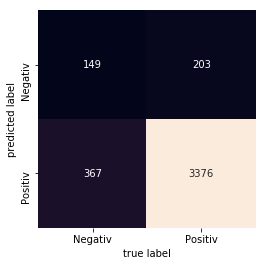

In [77]:
#Confusion matrix of model
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

labels = model.predict(X_test)
target_names = ['Negativ', 'Positiv']
mat = confusion_matrix(y_test, labels)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.show()

In [12]:
from sklearn.model_selection import cross_val_score,  KFold

#kfold
kfold = KFold(n_splits=5)

#StratifiedKFold
#standard for cv=INT is stratified k-fold

scores = cross_val_score(pipeline, X_train, y_train, cv=5)
print("Cross-validation scores: {}".format(scores))
print("Mean accuracy: {}".format(scores.mean()))

Cross-validation scores: [0.86389991 0.86172161 0.86748092 0.86015267 0.85954198]
Mean accuracy: 0.8625594185387098


In [13]:
from sklearn.model_selection import cross_validate
res = cross_validate(pipeline, X_train, y_train, cv=5, return_train_score=True)

#make DataFrame of result for better Visualisation
res_df = pd.DataFrame(res)
display(res_df)

#Print Mean of all Scores
print("Mean times and scores:\n", res_df.mean())

,fit_time,score_time,test_score,train_score
0,0.927593,0.248339,0.863900,0.931761
1,0.971764,0.211950,0.861722,0.932835
2,0.897761,0.265802,0.867481,0.936961
3,0.923044,0.170544,0.860153,0.932382
4,0.863198,0.170545,0.859542,0.932687


Mean times and scores:
 fit_time       0.916672
score_time     0.213436
test_score     0.862559
train_score    0.933325
dtype: float64


### Untersuchung der Predictions

In [86]:
# Erstellung eines DataFrames mit den Spalten: X_test, y_test, prediction
predictions = model.predict(X_test)
df_prediction = pd.DataFrame({
    'X_test': X_test,
    'y_test': y_test,
    'prediction': predictions
})

# neue Spalte, die Values von Spalten y_test und prediction vergleicht
df_prediction['vergleich'] = df_prediction['y_test'] == df_prediction['prediction']

df_prediction.head()

,X_test,y_test,prediction,vergleich
15806,"['tire', 'gauges', 'kind', 'thing', 'makes', '...",positiv,positiv,True
541,"['like', 'said', 'title', 'review', 'say', 'pr...",positiv,positiv,True
1724,"['comfortable', 'product', 'eliminate', 'stubb...",positiv,positiv,True
3586,"['must', 'tool', 'people', 'work', 'cars', 'se...",positiv,positiv,True
15830,"['purchased', 'joe', 'racing', 'pressure', 'ga...",positiv,positiv,True


In [87]:
# Speichern der Zeilen mit unterschiedlichen Werten in den Spalten "y_test" und "prediction" in einem neuen DF 
# und setzt Index zurück 
df_false_predictions = df_prediction[df_prediction.vergleich == False].reset_index(drop = True)

df_false_predictions.head()

,X_test,y_test,prediction,vergleich
0,"['regulator', 'well', 'made', 'leak', 'job', '...",negativ,positiv,False
1,"['sleek', 'easy', 'mount', 'note', 'middle', '...",negativ,positiv,False
2,['ok'],positiv,negativ,False
3,"['never', 'used', 'product', 'told', 'many', '...",positiv,negativ,False
4,"['many', 'pleats', 'prius', 'oem', 'material',...",positiv,negativ,False


In [88]:
# Erstellung einer CSV Datei mit den falsch predicteden Zeilen
df_false_predictions.to_csv("false_predictions.csv", sep=';',index=False)

In [89]:
# Ausgabe eines Reviews, das negativ ist aber positiv predicted wurde
df_false_predictions['X_test'].iloc[0]

"['regulator', 'well', 'made', 'leak', 'job', 'improve', 'flow', 'rate', 'materially', 'least', 'compared', 'much', 'cheaper', 'thirty-four', 'regular', 'thirty-four', 'regulator', 'bottom', 'line', 'worth', 'extra', 'money']"

In [90]:
# Ausgabe eines Reviews, das positiv ist aber negativ predicted wurde
# Zu Errinerung y_test: positiv ist 4 oder 5 Sterne, negativ ist kleiner gleich 3 Sterne
df_false_predictions['X_test'].iloc[3]

"['never', 'used', 'product', 'told', 'many', 'try', 'disappointed', 'applied', 'paper', 'towel', 'wash', 'say', 'rains', 'water', 'seems', 'fly', 'windshield', 'pushed', 'air', 'dryer', 'application', 'seems', 'last', 'well', 'twenty-three', 'weeks', 'wash', 'try', 'disappointed']"